# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 26.03.2025

Мягкий дедлайн: 13.04.2025 23:59 MSK

Жёсткий дедлайн: 17.04.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning.



In [67]:
pip install haversine

In [21]:
import pandas as pd
import numpy as np
from collections import defaultdict
import haversine

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

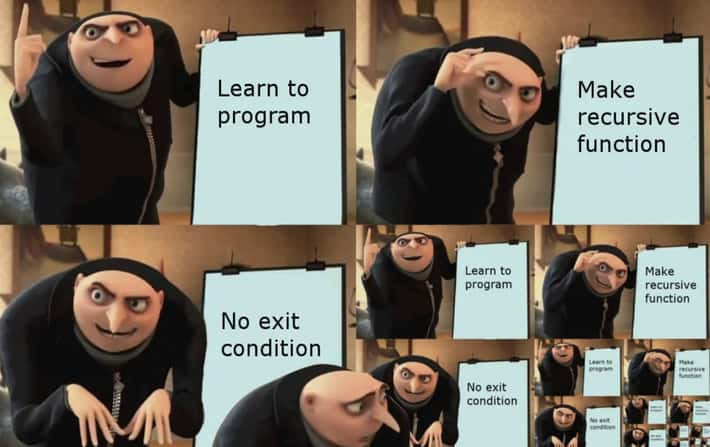

In [160]:
from IPython.display import display
from PIL import Image
import requests
from io import BytesIO

url = "https://imgix.ranker.com/user_node_img/50100/1001983281/original/recursion-photo-u1?auto=format&q=60&fit=crop&fm=pjpg&dpr=2&w=355"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
display(img)

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [87]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        self.eigenvectors_ = eigenvectors
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''

        diagonals = [sum(i) for i in X]
        D = np.diag(diagonals)
        L = D - X
        _, eigenvectors = np.linalg.eigh(L)
        return eigenvectors[:, :self.n_components]

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [22]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Альтернативная ссылка: [отсюда](https://disk.yandex.ru/i/J0HlcDXd_KyIeg). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [23]:
data = pd.read_excel('transport.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en                                            Name_en  \
0    278    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    279    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    355    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    356    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    357    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [24]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [76]:
def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''
    dct = defaultdict(list)
    for row in data.itertuples():
      routes = row.RouteNumbers_en.split(';')
      for route in routes:
        dct[route].append(row.ID_en)
    return dct


def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''

    for route, stops in routes.items():
      distances = []
      for stop in stops:
        dest_long = data[data['ID_en'] == stop]['Longitude_WGS84_en'].iloc[0]
        dest_lat = data[data['ID_en'] == stop]['Latitude_WGS84_en'].iloc[0]
        distances.append([dest_long, dest_lat])

      n = len(distances)
      dist_matrix = np.zeros((n, n))

      for i in range(n):
        for j in range(n):
          lon1, lat1 = distances[i]
          lon2, lat2 = distances[j]
          dist_matrix[i, j] = haversine((lat1, lon1), (lat2, lon2))

      n = dist_matrix.shape[0]
      max_dist = -1
      start_i, start_j = -1, -1
      for i in range(n):
        for j in range(n):
          if i != j and dist_matrix[i, j] > max_dist:
            max_dist = dist_matrix[i, j]
            start_i, start_j = i, j

      visited = [start_i]
      remaining = set(range(n)) - set(visited)

      while remaining:
        last = visited[-1]
        nearest = min(remaining, key=lambda x: dist_matrix[last, x])

        visited.append(nearest)
        remaining.remove(nearest)

      ordered_stop_ids = [stops[i] for i in visited]
      dct[route] = ordered_stop_ids

    return dct


def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''
    stop_ids = sorted(data['ID_en'])
    id_to_index = {stop_id: i for i, stop_id in enumerate(stop_ids)}
    n = len(stop_ids)

    adj_matrix = np.zeros((n, n))
    edge_counts = defaultdict(int)

    for route, stops in sorted_routes.items():
      for i in range(len(stops) - 1):
            u, v = stops[i], stops[i + 1]
            edge = tuple(sorted((u, v)))
            edge_counts[edge] += 1

    for (u, v), weight in edge_counts.items():
        i, j = id_to_index[u], id_to_index[v]
        adj_matrix[i][j] = weight
        adj_matrix[j][i] = weight

    return adj_matrix

In [77]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [80]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)

for route_id in np.random.choice(list(sorted_routes.keys()), size=5, replace=False):
    stop_ids = sorted_routes[route_id]
    coords_df = data[data['ID_en'].isin(stop_ids)][
        ['ID_en', 'Latitude_WGS84_en', 'Longitude_WGS84_en']
    ]
    coords_df['sort_order'] = coords_df['ID_en'].apply(lambda x: stop_ids.index(x))
    coords_df = coords_df.sort_values('sort_order')

    coords = coords_df[['Latitude_WGS84_en', 'Longitude_WGS84_en']].values.tolist()

    folium.PolyLine(coords, color='blue', weight=3, opacity=0.7).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [115]:
from matplotlib import cm
from matplotlib import colors
def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''
    map = folium.Map([55.75215, 37.61819], zoom_start=11)

    num_clusters = len(set(labels))
    colormap = cm.get_cmap('tab10', num_clusters)
    norm = colors.Normalize(vmin=0, vmax=num_clusters - 1)

    for i, row in data.iterrows():
        lat = row['Latitude_WGS84_en']
        lon = row['Longitude_WGS84_en']
        label = labels[i]
        color = colors.rgb2hex(colormap(norm(label)))
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.8
        ).add_to(map)

    return map

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации и подберите гиперпараметры так, чтобы кластеры получились осмысленными (нет такого, что все принадлежит одному кластеру или большая часть точек это шум):
- `sklearn.clustering.KMeans` - `n_clusters`
- `sklearn.clustering.DBSCAN` - `eps`
- ваш `SpectralClustering` - `n_clusters` и `n_components`

Для ряда алгоритмов, в частности DBSCAN, подобрать оптимальные параметры может быть ой, как непросто. Чтобы помочь сохранить нервные клетки рекомендуется пользоваться метриками Intrinsic Evaluation для кластеризации. Для каждого алгоритма скорее всего придется брать разные метрики, а может быть оптимизировать сразу несколько.

Ваша задача - выбрать подходящую метрику, можно взять что-то из списка ниже, можно спросить у гугла. Применить GridSearch, `optuna` или `hyperopt` и желательно завернуть отбор параметров в функцию, пригодится далее

1. $
   \text{Calinski-Harabasz Index} \in [0, \inf] = \frac{\sum_{i=1}^k BCSS_i/(k-1)}{\sum_{i=1}^k WCSS_i/(n-k)} = \frac{\sum_{i=1}^k n_i \| \mathbf{c}_i - \mathbf{c} \|^2/(k-1)}{\sum_{i=1}^k \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \mathbf{c}_i\|^2/(n-k)} \rightarrow max
   $
   - Отношение 1) расстояния от центра кластера до центра всех данных к 2) расстоянию от центра кластера до точки
   - Чем однороднее и дальше друг от друга кластеры, тем лучше
2. $
   \text{Silhouette Score} \in [0, 1] = \sum_i \frac{b_i - a_i}{\max(a_i, b_i)} \rightarrow max
   $
   - $a_i$ - среднее расстояние до точек внутри своего кластера
   - $b_i$ - среднее расстояние до точек из ближайшего кластера
   - Если в своем кластере точки близко - кластер плотный, идеальный вариант, скор равен 1, если свой кластер совпадает с соседним - кластеры неразделимы, скор равен нулю
   - Чем однороднее и разделимее кластеры, тем лучше
3. $\text{Davies-Bouldin Index} \in [0, inf] = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{WCSS_i + WCSS_j}{d(c_i, c_j)} \right) \rightarrow min $
   - Отношение внутрикластерных расстояний к межкластерному расстоянию между двумя центрами
   - Если кластеры далеко друг от друга, но при этом однородные, скор наименьший
3. $\text{Elbow Method}$ - последовательное сравнение $WCSS$ из пункта 1 для разного числа параметров. Если уменьшение меньше определенного порога - останавливаемся, считаем это значение оптимальным

In [18]:
from tabulate import tabulate

In [82]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.1 MB/s eta 0:00:00


In [99]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN, KMeans
import optuna
def optimize_kmeans(X):
    def objective(trial):
        n_clusters = trial.suggest_int("n_clusters", 2, 15)
        model = KMeans(n_clusters=n_clusters)
        labels = model.fit_predict(X)
        if len(set(labels)) < 2:
            return -1.0
        return silhouette_score(X, labels)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    return study

def optimize_dbscan(X_rad):
    def objective(trial):
        eps = trial.suggest_float("eps", 0.001, 0.05, step=0.001)
        model = DBSCAN(eps=eps)
        labels = model.fit_predict(X_rad)
        mask = labels != -1
        if len(set(labels[mask])) < 2:
            return -1.0
        return silhouette_score(X_rad[mask], labels[mask])

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    return study

def optimize_graph(adjacency_matrix):
    def objective(trial):
        n_clusters = trial.suggest_int("n_clusters", 2, 15)
        n_components = trial.suggest_int("n_components", 2, 15)
        model = GraphClustering(n_clusters=n_clusters, n_components=n_components)
        labels = model.fit_predict(adjacency_matrix)
        if len(set(labels)) < 2:
            return -1.0
        return silhouette_score(model.eigenvectors_[:, 1:], labels)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    return study

In [90]:
X = data[['Latitude_WGS84_en', 'Longitude_WGS84_en']].to_numpy()
X_rad = np.radians(X)

In [94]:
study_kmeans = optimize_kmeans(X)
best_params_kmeans = study_kmeans.best_params

[I 2025-04-12 09:49:49,937] A new study created in memory with name: no-name-9f6c1e53-2a3f-405e-ba79-945bef7eb5f8
[I 2025-04-12 09:49:49,968] Trial 0 finished with value: 0.3898613545885049 and parameters: {'n_clusters': 5}. Best is trial 0 with value: 0.3898613545885049.
[I 2025-04-12 09:49:50,018] Trial 1 finished with value: 0.413667225741214 and parameters: {'n_clusters': 4}. Best is trial 1 with value: 0.413667225741214.
[I 2025-04-12 09:49:50,076] Trial 2 finished with value: 0.38017111780622265 and parameters: {'n_clusters': 6}. Best is trial 1 with value: 0.413667225741214.
[I 2025-04-12 09:49:50,148] Trial 3 finished with value: 0.405852520372769 and parameters: {'n_clusters': 12}. Best is trial 1 with value: 0.413667225741214.
[I 2025-04-12 09:49:50,201] Trial 4 finished with value: 0.3916796593602317 and parameters: {'n_clusters': 15}. Best is trial 1 with value: 0.413667225741214.
[I 2025-04-12 09:49:50,250] Trial 5 finished with value: 0.4816289539957489 and parameters: {'

In [100]:
study_dbscan = optimize_dbscan(X)
best_params_dbscan = study_dbscan.best_params

[I 2025-04-12 09:52:29,248] A new study created in memory with name: no-name-fc2723f9-80a4-4457-866d-3c1c0dba0b8b
[I 2025-04-12 09:52:29,262] Trial 0 finished with value: -1.0 and parameters: {'eps': 0.013000000000000001}. Best is trial 0 with value: -1.0.
[I 2025-04-12 09:52:29,274] Trial 1 finished with value: -1.0 and parameters: {'eps': 0.016}. Best is trial 0 with value: -1.0.
[I 2025-04-12 09:52:29,292] Trial 2 finished with value: -1.0 and parameters: {'eps': 0.042}. Best is trial 0 with value: -1.0.
[I 2025-04-12 09:52:29,307] Trial 3 finished with value: -1.0 and parameters: {'eps': 0.029}. Best is trial 0 with value: -1.0.
[I 2025-04-12 09:52:29,323] Trial 4 finished with value: -1.0 and parameters: {'eps': 0.036000000000000004}. Best is trial 0 with value: -1.0.
[I 2025-04-12 09:52:29,340] Trial 5 finished with value: -1.0 and parameters: {'eps': 0.036000000000000004}. Best is trial 0 with value: -1.0.
[I 2025-04-12 09:52:29,356] Trial 6 finished with value: -1.0 and paramet

In [101]:
study_graph = optimize_graph(adjacency_matrix)
best_params_graph = study_graph.best_params

[I 2025-04-12 09:53:42,598] A new study created in memory with name: no-name-bfe0b1b1-519a-4cd3-b4db-9fb2c22348a6
[I 2025-04-12 09:53:43,353] Trial 0 finished with value: 0.9980713560165867 and parameters: {'n_clusters': 11, 'n_components': 3}. Best is trial 0 with value: 0.9980713560165867.
[I 2025-04-12 09:53:43,926] Trial 1 finished with value: 0.9490698971479558 and parameters: {'n_clusters': 5, 'n_components': 9}. Best is trial 0 with value: 0.9980713560165867.
[I 2025-04-12 09:53:46,218] Trial 2 finished with value: 0.9810924943139684 and parameters: {'n_clusters': 5, 'n_components': 3}. Best is trial 0 with value: 0.9980713560165867.
[I 2025-04-12 09:53:47,356] Trial 3 finished with value: 0.9461946150510956 and parameters: {'n_clusters': 4, 'n_components': 10}. Best is trial 0 with value: 0.9980713560165867.
[I 2025-04-12 09:53:47,954] Trial 4 finished with value: 0.9448896384341663 and parameters: {'n_clusters': 2, 'n_components': 13}. Best is trial 0 with value: 0.99807135601

In [111]:
table = [
    ['KMeans', best_params_kmeans],
    ['DBSCAN', best_params_dbscan],
    ['Graph', best_params_graph]
]

print(tabulate(table, headers=['Model', 'Best Params']))

Model    Best Params
-------  -------------------------------------
KMeans   {'n_clusters': 2}
DBSCAN   {'eps': 0.001}
Graph    {'n_clusters': 10, 'n_components': 3}


In [107]:
model_kmeans = KMeans(**best_params_kmeans)
labels_kmeans = model_kmeans.fit_predict(X)

model_dbscan = DBSCAN(**best_params_dbscan)
labels_dbscan = model_dbscan.fit_predict(X)

model_graph = GraphClustering(**best_params_graph)
labels_graph = model_graph.fit_predict(adjacency_matrix)


sil_k = silhouette_score(X, labels_kmeans)
db_k = davies_bouldin_score(X, labels_kmeans)
ch_k = calinski_harabasz_score(X, labels_kmeans)

mask_dbscan = labels_dbscan != -1
sil_d = silhouette_score(X[mask_dbscan], labels_dbscan[mask_dbscan])
db_d = davies_bouldin_score(X[mask_dbscan], labels_dbscan[mask_dbscan])
ch_d = calinski_harabasz_score(X[mask_dbscan], labels_dbscan[mask_dbscan])

eig = model_graph.eigenvectors_[:, 1:]
sil_g = silhouette_score(eig, labels_graph)
db_g = davies_bouldin_score(eig, labels_graph)
ch_g = calinski_harabasz_score(eig, labels_graph)

results = [
    ['KMeans', sil_k, db_k, ch_k],
    ['DBSCAN', sil_d, db_d, ch_d],
    ['Graph', sil_g, db_g, ch_g],
]

print(tabulate(results, headers=['Model', 'Silhouette', 'DB Index', 'Calinski-Harabasz'], floatfmt=".3f"))

Model      Silhouette    DB Index    Calinski-Harabasz
-------  ------------  ----------  -------------------
KMeans          0.482       0.764             1501.896
DBSCAN          0.842       0.203            10357.330
Graph           0.999       0.006        265830725.614


Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`.

In [117]:
draw_clustered_map(data, labels_graph)

<ipython-input-115-b02c6f498bdc>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', num_clusters)


**Вопрос:** Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:** KMeans работает так: мы заранее задаём число кластеров, и алгоритм разбивает точки на группы по принципу близости к центроидам. В случае остановок это означает, что мы просто ищем ближайшие остановки друг к другу и считаем, что они принадлежат к одному кластеру. Проблема в том, что близость по координатам не всегда значит логическую связанность. Например, остановки могут находиться рядом, но принадлежать разным маршрутам, идти в разные стороны или вообще не пересекаться. В результате у KMeans часто получаются неоднородные и пересекающиеся кластеры, что сказывается на метриках, они ниже, чем у других алгоритмов.

DBSCAN кластеризует точки по плотности, если точек много в ограниченном районе, он объединяет их в кластер. В теории это подходит для анализа остановок, но на практике есть нюанс: в центре города остановки расположены очень плотно, и DBSCAN часто объединяет почти все точки в один большой кластер. То есть он слишком усредняет, теряя полезную структуру. Несмотря на это, метрики у DBSCAN всё равно лучше, чем у KMeans — видимо, он лучше справляется с шумом и выбросами.

Спектральная кластеризация использует граф, она строит матрицу смежности, где ребра отражают как расстояние между остановками, так и частоту их совместного появления на маршрутах. За счёт этого подхода спектральный алгоритм учитывает и географическую близость, и логическую связанность. Это помогает избежать проблем, которые были у KMeans и DBSCAN: кластеры получаются более осмысленными и устойчивыми. На всех метриках спектральная кластеризация показала себя лучше остальных.

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [5]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
694   entertainment  185.txt   Oscar host Rock to keep it clean   
1884           tech  061.txt             Concern over RFID tags   
2146           tech  323.txt    Blind student 'hears in colour'   
744   entertainment  235.txt  Pop band Busted to 'take a break'   
1506          sport  194.txt   Klinsmann issues Lehmann warning   

                                                content  
694    Oscar host Chris Rock said he will steer clea...  
1884   Consumers are very concerned about the use of...  
2146   A blind student has developed software that t...  
744    Chart-topping pop band Busted have confirmed ...  
1506   Germany coach Jurgen Klinsmann has warned goa...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [9]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [10]:
from wordcloud import WordCloud

def draw_wordcloud(texts, ax, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

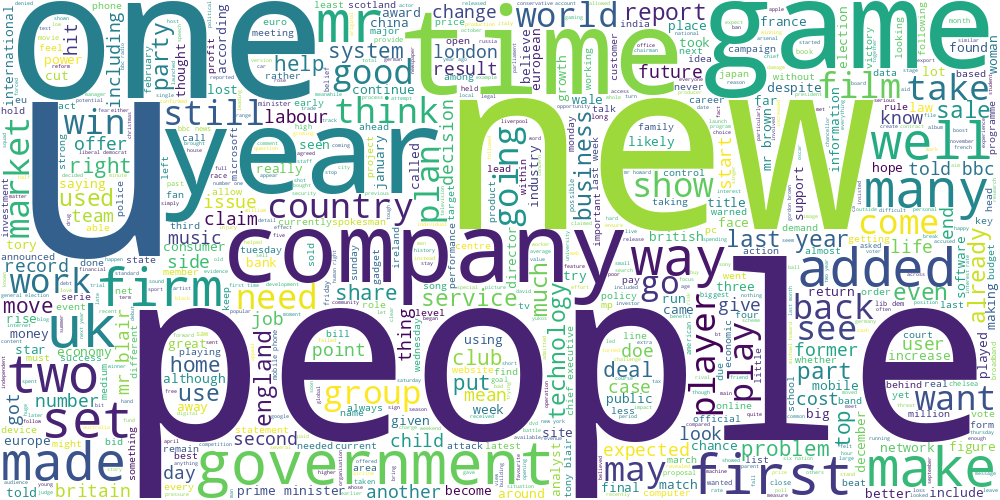

In [131]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров.

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.1)
tokenised = vectorizer.fit_transform(data['text'].to_list())
model = KMeans(n_clusters=8)
labels = model.fit_predict(tokenised)
data['cluster'] = labels

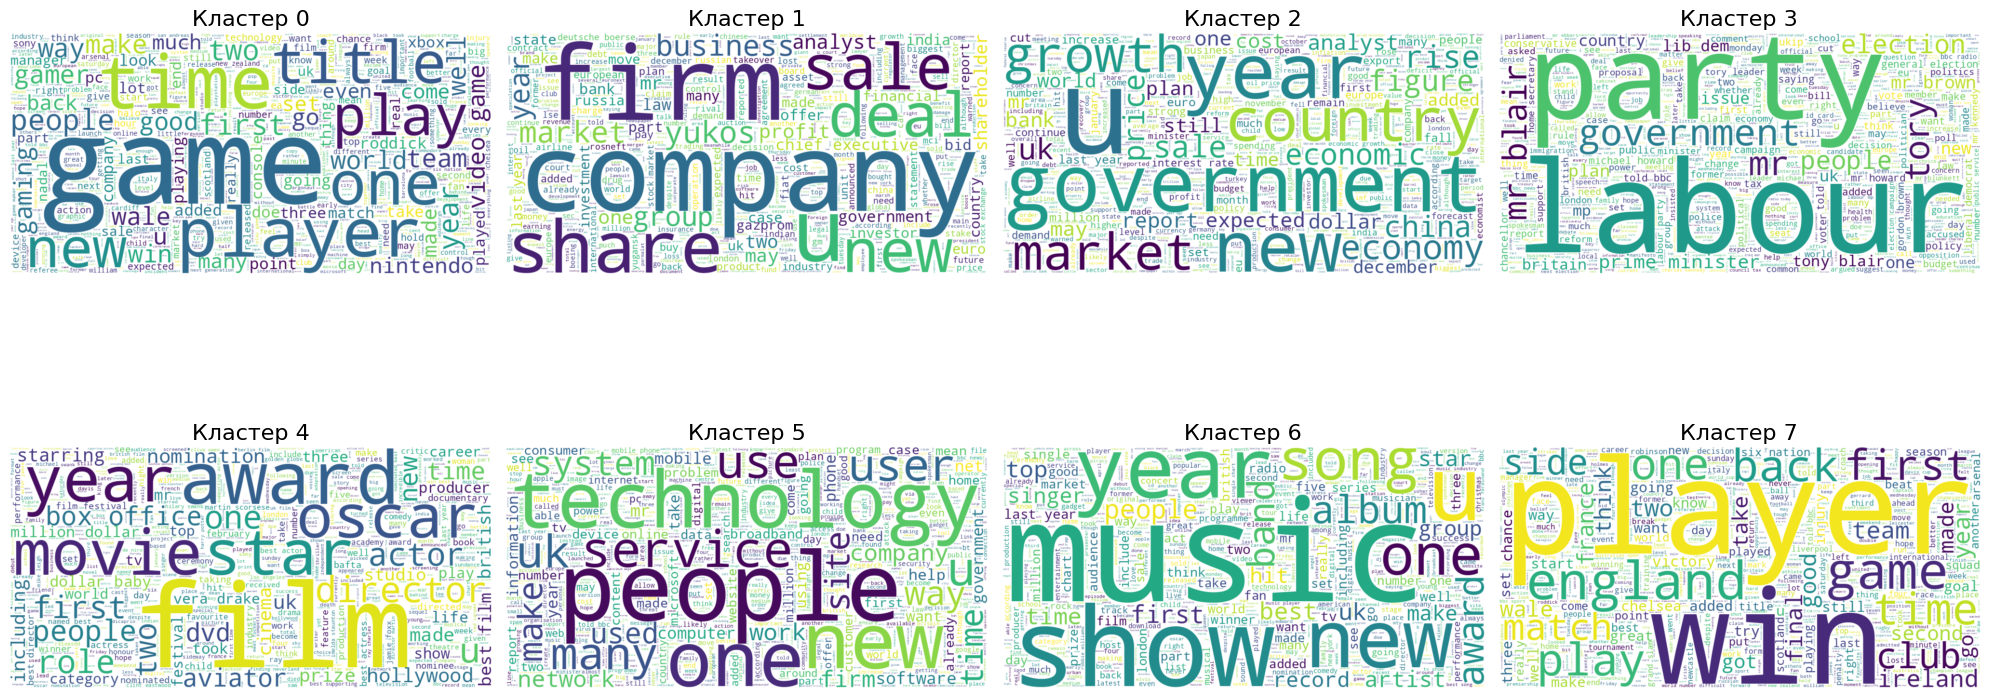

In [149]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(8):
    cluster_text = data[data['cluster'] == i]['text']
    draw_wordcloud(cluster_text, ax=axes[i])
    axes[i].set_title(f'Кластер {i}', fontsize=16)

plt.tight_layout()
plt.show()

Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**
Темы получились в целом интерпретируемыми — внутри каждого кластера слова связаны между собой и несут схожую смысловую нагрузку. Однако, на мой взгляд, некоторых кластеров получилось больше, чем нужно, и их можно было бы объединить. Кластеры 1 и 2 тематически близки: оба связаны с бизнесом и экономикой. Слова внутри кластеров перекрываются по смыслу, поэтому деление здесь кажется избыточным. Кластеры 4 и 6 — оба относятся к теме культуры. Кластер 4 больше про кино, а кластер 6 — про музыку, но в целом они относятся к одной тематической области. Кластеры 0 и 7 — оба связаны со спортом, и их тоже логично было бы объединить. Кластеры получились достаточно чёткими, но количество тематик можно сократить до 5–6. Вот как их можно озаглавить:


Кластеры 0 и 7 — спорт


Кластеры 1 и 2 — бизнес и экономика


Кластер 3 — политика и правительство


Кластеры 4 и 6 — культура


Кластер 5 — технологии

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны.

In [156]:
centers = model.cluster_centers_
terms = vectorizer.get_feature_names_out()
for i, center in enumerate(centers):
    max_index = np.argmax(center)
    max_term = terms[max_index]
    max_value = center[max_index]
    print(f"Кластер {i}: max word = '{max_term}', tf-idf = {max_value:.4f}")

Кластер 0: max word = 'game', tf-idf = 0.5056
Кластер 1: max word = 'company', tf-idf = 0.2095
Кластер 2: max word = 'growth', tf-idf = 0.1279
Кластер 3: max word = 'mr', tf-idf = 0.3211
Кластер 4: max word = 'film', tf-idf = 0.5783
Кластер 5: max word = 'people', tf-idf = 0.1530
Кластер 6: max word = 'music', tf-idf = 0.1998
Кластер 7: max word = 'england', tf-idf = 0.1057


Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:** Да, в целом полученные слова хорошо согласуются с облаками тегов из предыдущего задания. Почти во всех кластерах наблюдается совпадение ключевых слов и тематик. Есть небольшие расхождения в кластере 3 и кластере 7, где слова из облаков тегов и из кластеров частично отличаются, но в целом основная тема сохраняется. В остальных случаях соответствие достаточно точное.

**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров (подумайте, как это можно сделать)

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [51]:
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(tokenised)

spectral = SpectralClustering(n_clusters=5)
spectral_labels = spectral.fit_predict(tokenised)

best_eps = None
best_labels = None
best_diff = float('inf')

for eps in np.arange(0.1, 2.0, 0.05):
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(tokenised)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    diff = abs(n_clusters - 5)
    if diff < best_diff:
        best_diff = diff
        best_eps = eps
        dbscan_labels = labels

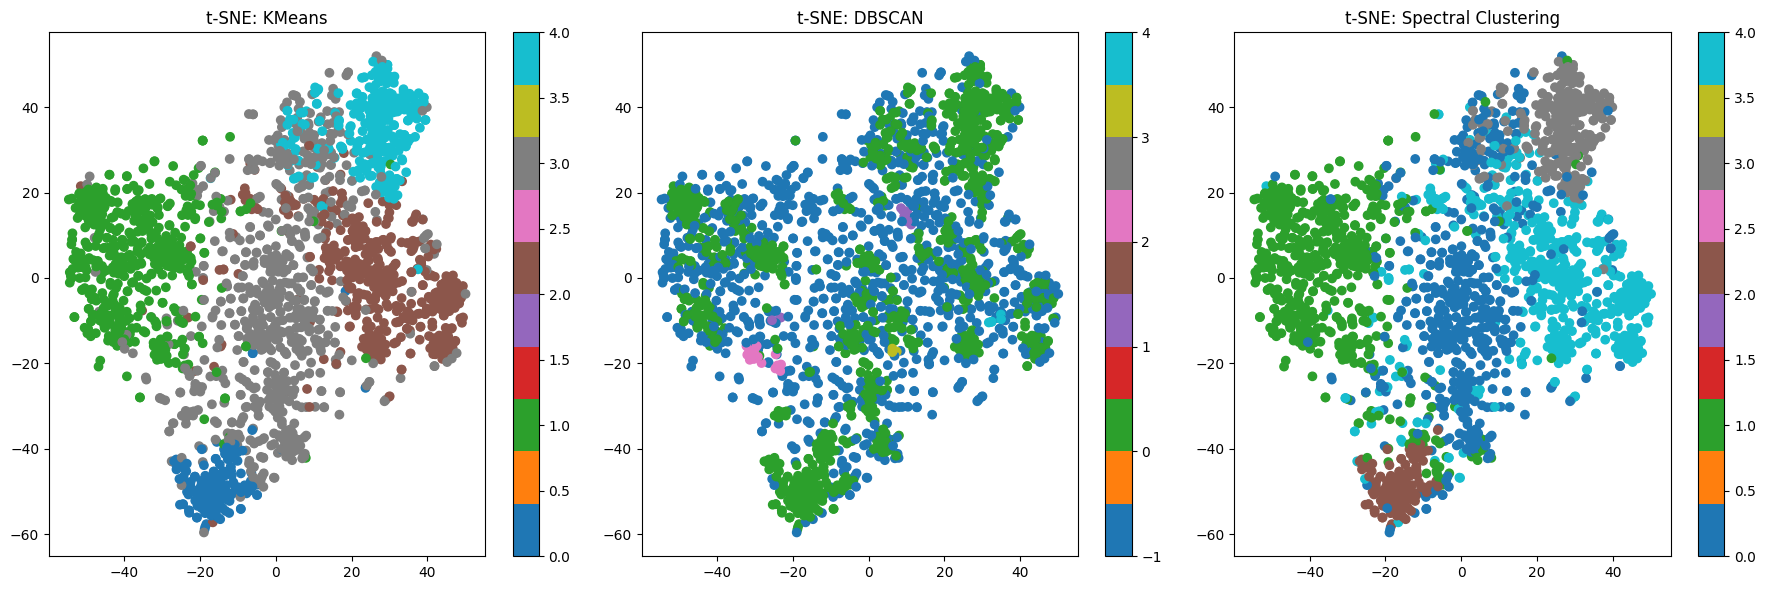

In [169]:
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(tokenised)

spectral = SpectralClustering(n_clusters=5)
spectral_labels = spectral.fit_predict(tokenised)

best_eps = None
best_labels = None
best_diff = float('inf')

for eps in np.arange(0.1, 2.0, 0.05):
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(tokenised)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    diff = abs(n_clusters - 5)
    if diff < best_diff:
        best_diff = diff
        best_eps = eps
        dbscan_labels = labels

tsne_tokenised = TSNE(init='random').fit_transform(tokenised)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(tsne_tokenised[:, 0], tsne_tokenised[:, 1], c=kmeans_labels, cmap='tab10')
plt.title('t-SNE: KMeans')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(tsne_tokenised[:, 0], tsne_tokenised[:, 1], c=dbscan_labels, cmap='tab10')
plt.title('t-SNE: DBSCAN')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(tsne_tokenised[:, 0], tsne_tokenised[:, 1], c=spectral_labels, cmap='tab10')
plt.title('t-SNE: Spectral Clustering')
plt.colorbar()

plt.tight_layout()
plt.show()

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:** У DBSCAN получилось довольно неудачное разбиение на кластеры. Как уже обсуждалось, из-за того что структура точек довольно плотная и сжатая, алгоритму сложно выделить чёткие границы между группами. Он как бы слишком сглаживает структуру данных и в итоге объединяет слишком много в один кластер или создаёт шум. А вот у KMeans и спектральной кластеризации получились похожие паттерны — они разбили тексты на кластеры достаточно логично, и группы оказались интерпретируемыми. Это интересно, потому что в случае географических данных KMeans, наоборот, дал худшее разбиение. Такое различие, скорее всего, связано с тем, что в текстах векторы, полученные после преобразования TF-IDF распределены более равномерно и линейно, чем координаты остановок в городе. KMeans лучше работает в ситуациях, где данные можно разделить на четкие области, и в текстах как раз такое распределение часто бывает — темы тяготеют к своим центрам, и границы между ними не такие резкие, как в пространстве реальных координат.

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means.

In [173]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
bg = cv.fit_transform(data['text'].to_list()).toarray()

lda = LatentDirichletAllocation(n_components=10)
predictions = lda.fit_transform(bg)

lda_labels = predictions.argmax(axis=1)

In [177]:
data['lda'] = lda_labels

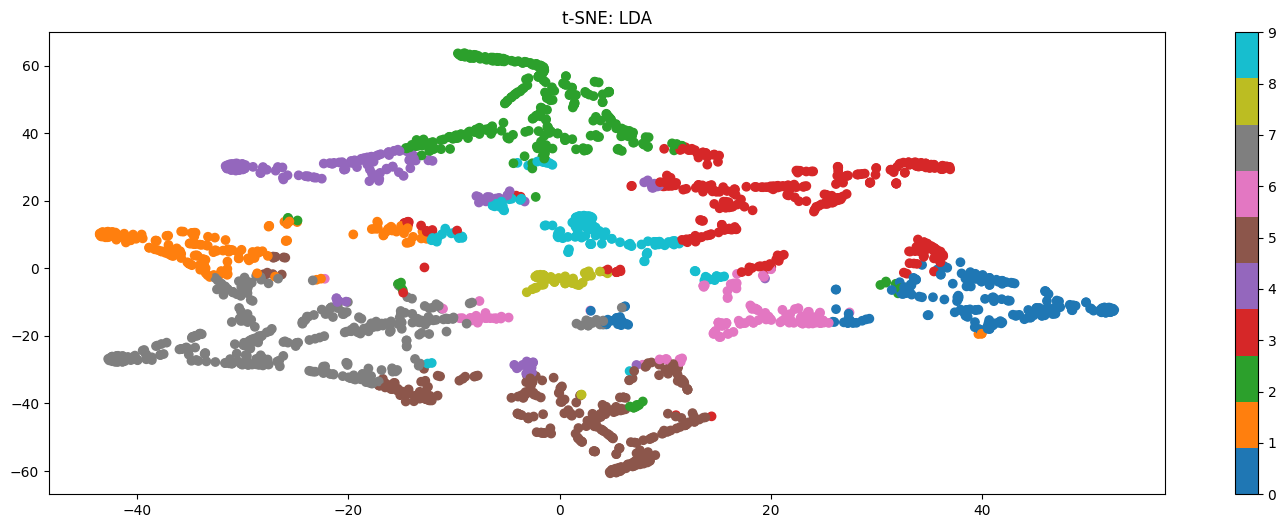

In [176]:
tsne_tokenised = TSNE(init='random').fit_transform(predictions)

plt.figure(figsize=(18, 6))
plt.scatter(tsne_tokenised[:, 0], tsne_tokenised[:, 1], c=lda_labels, cmap='tab10')
plt.title('t-SNE: LDA')
plt.colorbar()

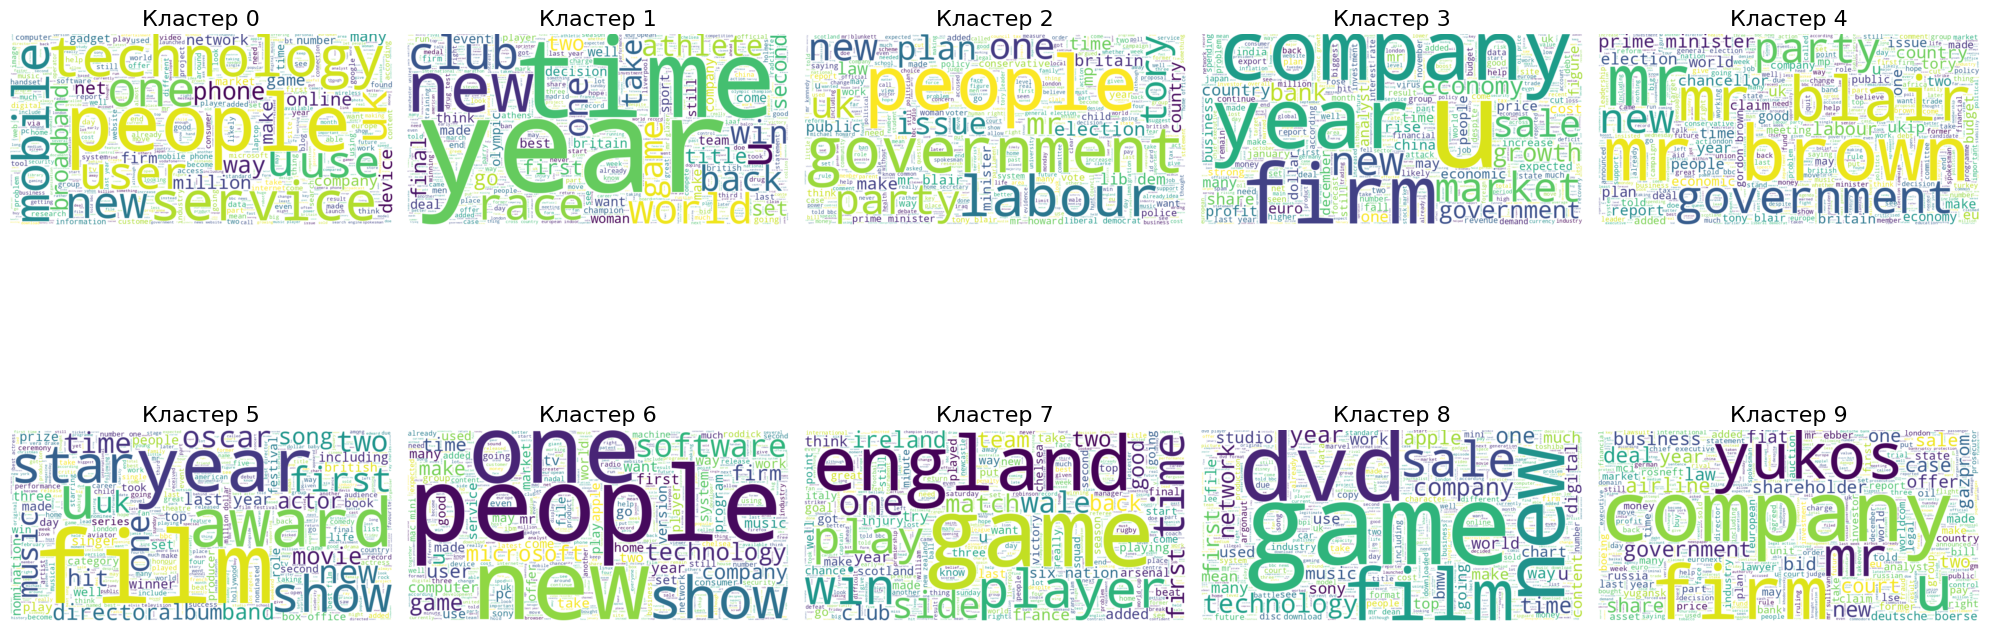

In [179]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i in range(10):
    cluster_text = data[data['lda'] == i]['text']
    draw_wordcloud(cluster_text, ax=axes[i])
    axes[i].set_title(f'Кластер {i}', fontsize=16)

plt.tight_layout()
plt.show()

Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:** Да, после такого нововведения темы действительно стали уже. Но границы между ними всё равно частично пересекаются. Например, кластер 0 и кластер 6 обе так или иначе связаны с технологиями: кластер 0 — скорее про мобильные технологии и повседневное использование, а кластер 6 — про крупные технологичные компании и бизнес-среду. Похожая ситуация с кластерами 3 и 9 — в обоих часто встречается слово компания , но контексты разные: кластер 3 больше про экономику и её развитие, а кластер 9 — про взаимодействие бизнеса и государства. То есть темы получаются уже, но не всегда строго разделёнными.

Думаю, степень детализации кластеров будет зависеть от задачи. Если нужно просто сгруппировать новости по тематикам на сайте, то такое дробление может быть избыточным. А вот если цель использовать темы для тегов или более точной категоризации, то, наоборот, такое деление вполне оправдано.

## Часть 3. Transfer learning и Self-Supervised Learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances

X = data['text']
y = data['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances

X = data['text']
y = data['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

log_tfidf = LogisticRegression(random_state=42).fit(X_train_tfidf, y_train)
y_pred_tfidf = log_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

kmeans = KMeans().fit(X_train_tfidf)
X_train_kmeans = pairwise_distances(X_train_tfidf, kmeans.cluster_centers_)
X_test_kmeans = pairwise_distances(X_test_tfidf, kmeans.cluster_centers_)

log_kmeans = LogisticRegression(random_state=42).fit(X_train_kmeans, y_train)
y_pred_kmeans = log_kmeans.predict(X_test_kmeans)
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)

cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train)
X_test_bow = cv.transform(X_test)

lda = LatentDirichletAllocation().fit(X_train_bow)
X_train_lda = lda.fit_transform(X_train_bow)
X_test_lda = lda.transform(X_test_bow)

log_lda = LogisticRegression(random_state=42).fit(X_train_lda, y_train)
y_pred_lda = log_lda.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

results = [
    ['Logistic Regression on tf-idf features', accuracy_tfidf],
    ['Kmeans on tf-idf features + Logistic Regression on centres', accuracy_kmeans],
    ['LDA + Logistic Regression', accuracy_lda],
]

print(tabulate(results, headers=['Model', 'Accuracy Score on Test Sample'], floatfmt=".3f"))

Model                                                         Accuracy Score on Test Sample
----------------------------------------------------------  -------------------------------
Logistic Regression on tf-idf features                                                0.973
Kmeans on tf-idf features + Logistic Regression on centres                            0.810
LDA + Logistic Regression                                                             0.934


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** Лучшее качество показала модель Logistic Regression на tf-idf признаках. Это можно объяснить тем, что tf-idf довольно точно отражает конкретные слова, которые встречаются в тексте, и их важность. В задачах, где нужно классифицировать тексты по темам, такие признаки могут быть очень полезны, особенно если темы явно различаются по лексике.

В отличие от тематических моделей вроде LDA, tf-idf даёт более детализированное и точное представление текста, хоть и в разреженном виде. Логистическая регрессия, особенно при регуляризации, хорошо справляется с такими высокоразмерными данными, и может выучить надёжные веса для классификации.

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации.

In [182]:
X_sup, X_temp, y_sup, y_temp = train_test_split(X_train, y_train, test_size=0.95, random_state=42)
X_unsup, X_val, y_unsup, y_val = train_test_split(X_temp, y_temp, test_size=30/(65+30), random_state=42)

X_semi = pd.concat([X_sup, X_unsup])
y_semi = pd.concat([y_sup, y_unsup])

vectorizer_tfidf = TfidfVectorizer()
X_semi_tfidf = vectorizer_tfidf.fit_transform(X_semi)
X_sup_tfidf = vectorizer_tfidf.transform(X_sup)
X_val_tfidf = vectorizer_tfidf.transform(X_val)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

log_tfidf = LogisticRegression (random_state=42).fit(X_sup_tfidf, y_sup)
val_preds_tfidf = log_tfidf.predict(X_val_tfidf)
test_preds_tfidf = log_tfidf.predict(X_test_tfidf)

acc_test_tfidf = accuracy_score(y_test, test_preds_tfidf)

#  === === === === === === === === === === === === === === === === === === === === === === === === === === === ===
best_k = None
best_acc = 0
best_model = None

for k in [5, 10, 15, 20, 30]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_semi_tfidf)

    X_semi_dist = pairwise_distances(X_semi_tfidf, kmeans.cluster_centers_)
    X_sup_dist = X_semi_dist[:len(X_sup)]
    X_val_dist = pairwise_distances(X_val_tfidf, kmeans.cluster_centers_)
    X_test_dist = pairwise_distances(X_test_tfidf, kmeans.cluster_centers_)

    clf = LogisticRegression( random_state=42).fit(X_sup_dist, y_sup)

    val_preds = clf.predict(X_val_dist)
    acc = accuracy_score(y_val, val_preds)

    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_model = clf

acc_test_kmeans = accuracy_score(y_test, best_model.predict(X_test_dist))

#  === === === === === === === === === === === === === === === === === === === === === === === === === === === ===

best_n = None
best_acc_lda = 0
best_model_lda = None

vectorizer_bow = CountVectorizer()
X_semi_bow = vectorizer_bow.fit_transform(X_semi)
X_sup_bow = vectorizer_bow.transform(X_sup)
X_val_bow = vectorizer_bow.transform(X_val)
X_test_bow = vectorizer_bow.transform(X_test)

for n_topics in [5, 10, 15, 20, 30]:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    X_semi_topics = lda.fit_transform(X_semi_bow)
    X_sup_topics = X_semi_topics[:len(X_sup)]
    X_val_topics = lda.transform(X_val_bow)
    X_test_topics = lda.transform(X_test_bow)

    clf = LogisticRegression(random_state=42)
    clf.fit(X_sup_topics, y_sup)

    val_preds = clf.predict(X_val_topics)
    acc = accuracy_score(y_val, val_preds)

    if acc > best_acc_lda:
        best_acc_lda = acc
        best_model_lda = clf
        X_test_lda_best = X_test_topics

acc_test_lda = accuracy_score(y_test, best_model_lda.predict(X_test_lda_best))

results = [
    ['Logistic Regression on tf-idf features', accuracy_tfidf, acc_test_tfidf],
    ['Kmeans on tf-idf features + Logistic Regression on centres', accuracy_kmeans, acc_test_kmeans],
    ['LDA + Logistic Regression', accuracy_lda, acc_test_lda],
]

print(tabulate(results, headers=['Model', 'Accuracy Score on Test Sample', 'Accuracy Score on Test Sample Semisupervised'], floatfmt=".3f"))

Model                                                         Accuracy Score on Test Sample    Accuracy Score on Test Sample Semisupervised
----------------------------------------------------------  -------------------------------  ----------------------------------------------
Logistic Regression on tf-idf features                                                0.973                                           0.560
Kmeans on tf-idf features + Logistic Regression on centres                            0.810                                           0.268
LDA + Logistic Regression                                                             0.934                                           0.750


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** После уменьшения объёма размеченных данных лучшее качество показала модель LDA + Logistic Regression. Это связано с тем, что в отличие от tf-idf, LDA выделяет тематическую структуру текста, а не просто считает частоты слов. На выходе мы получаем вектор вероятностей тем для каждого документа по сути, это компактное и осмысленное представление его содержания. Такие признаки менее разреженные, чем tf-idf, и при этом низкоразмерные и интерпретируемые, что делает обучение логистической регрессии более стабильным. Когда размеченных данных очень мало , это особенно важно, потому что нижение размерности и избавление от шума позволяет модели не переобучаться и лучше обобщать.

## Бонус

**Задание 4 (0.5 балла)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [30]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
X_sup, X_temp, y_sup, y_temp = train_test_split(X_train, y_train, test_size=0.95, random_state=42)
X_unsup, X_val, y_unsup, y_val = train_test_split(X_temp, y_temp, test_size=30/(65+30), random_state=42)

X_semi = pd.concat([X_sup, X_unsup])
y_semi = pd.concat([y_sup, y_unsup])
le = LabelEncoder()
y_semi= le.fit_transform(y_semi)
y_test = le.transform(y_test)
y_sup = le.transform(y_sup)
y_semi_masked = y_semi.copy()
y_semi_masked[len(y_sup):] = -1

vectorizer_tfidf = TfidfVectorizer()
X_semi_tfidf = vectorizer_tfidf.fit_transform(X_semi)
X_sup_tfidf = vectorizer_tfidf.transform(X_sup)
X_val_tfidf = vectorizer_tfidf.transform(X_val)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# === Self-Training ===
base_clf = LogisticRegression(max_iter=1000, random_state=42)
self_training_model = SelfTrainingClassifier(base_clf).fit(X_semi_tfidf, y_semi_masked)
test_preds_tfidf_1 = self_training_model.predict(X_test_tfidf)
acc_test_tfidf_st = accuracy_score(y_test, test_preds_tfidf_1)

# === LabelPropagation ===
label_prop_model = LabelPropagation().fit(X_semi_tfidf, y_semi_masked)
test_preds_tfidf_2 = label_prop_model.predict(X_test_tfidf)
acc_test_tfidf_lp = accuracy_score(y_test, test_preds_tfidf_2)

# === LabelSpreading ===
label_spread_model = LabelSpreading().fit(X_semi_tfidf, y_semi_masked)
test_preds_tfidf_3 = label_spread_model.predict(X_test_tfidf)
acc_test_tfidf_ls = accuracy_score(y_test, test_preds_tfidf_3)
#  === === === === === === === === === === === === === === === === === === === === === === === === === === === ===
kmeans = KMeans(random_state=42).fit(X_semi_tfidf)

X_semi_dist = pairwise_distances(X_semi_tfidf, kmeans.cluster_centers_)
X_sup_dist = X_semi_dist[:len(X_sup)]
X_val_dist = pairwise_distances(X_val_tfidf, kmeans.cluster_centers_)
X_test_dist = pairwise_distances(X_test_tfidf, kmeans.cluster_centers_)

# === Self-Training ===
clf = LogisticRegression(random_state=42).fit(X_sup_dist, y_sup)
self_training_model = SelfTrainingClassifier(clf).fit(X_semi_dist, y_semi_masked)
test_preds_kmeans_1 = self_training_model.predict(X_test_dist)
acc_test_kmeans_st = accuracy_score(y_test, test_preds_kmeans_1)

# === LabelPropagation ===
label_prop_model = LabelPropagation().fit(X_semi_dist, y_semi_masked)
test_preds_kmeans_2 = label_prop_model.predict(X_test_dist)
acc_test_kmeans_lp = accuracy_score(y_test, test_preds_kmeans_2)

# === LabelSpreading ===
label_spread_model = LabelSpreading().fit(X_semi_dist, y_semi_masked)
test_preds_kmeans_3 = label_spread_model.predict(X_test_dist)
acc_test_kmeans_ls = accuracy_score(y_test, test_preds_kmeans_3)

# === === === === === === === === === === === === === === === === === === === === === === === === === === === ===
vectorizer_bow = CountVectorizer()
X_semi_bow = vectorizer_bow.fit_transform(X_semi)
X_sup_bow = vectorizer_bow.transform(X_sup)
X_val_bow = vectorizer_bow.transform(X_val)
X_test_bow = vectorizer_bow.transform(X_test)

lda = LatentDirichletAllocation(random_state=42)
X_semi_topics = lda.fit_transform(X_semi_bow)
X_sup_topics = X_semi_topics[:len(X_sup)]
X_val_topics = lda.transform(X_val_bow)
X_test_topics = lda.transform(X_test_bow)

# === Self-Training ===
clf = LogisticRegression(random_state=42).fit(X_sup_topics, y_sup)
self_training_model = SelfTrainingClassifier(clf).fit(X_semi_topics, y_semi_masked)
test_preds_lda_1 = self_training_model.predict(X_test_topics)
acc_test_lda_st = accuracy_score(y_test, test_preds_lda_1)

# === LabelPropagation ===
label_prop_model = LabelPropagation().fit(X_semi_topics, y_semi_masked)
test_preds_lda_2 = label_prop_model.predict(X_test_topics)
acc_test_lda_lp = accuracy_score(y_test, test_preds_lda_2)

# === LabelSpreading ===
label_spread_model = LabelSpreading().fit(X_semi_topics, y_semi_masked)
test_preds_lda_3 = label_spread_model.predict(X_test_topics)
acc_test_lda_ls = accuracy_score(y_test, test_preds_lda_3)

results = [
    ['Logistic Regression on tf-idf features', accuracy_tfidf, acc_test_tfidf, acc_test_tfidf_st, acc_test_tfidf_lp, acc_test_kmeans_ls],
    ['Kmeans on tf-idf features + Logistic Regression on centres', accuracy_kmeans, acc_test_kmeans, acc_test_kmeans_st, acc_test_kmeans_lp, acc_test_kmeans_ls],
    ['LDA + Logistic Regression', accuracy_lda, acc_test_lda, acc_test_lda_st, acc_test_lda_lp, acc_test_lda_ls],
]

print(tabulate(results, headers=['Model', 'Accuracy Score on Test Sample', 'Accuracy Score on Test Sample Semisupervised', 'Accuracy Score on Self-Training', 'Accuracy Score on LabelPropagation', 'Accuracy Score on LabelSpreading'], floatfmt=".3f"))

Model                                                         Accuracy Score on Test Sample    Accuracy Score on Test Sample Semisupervised    Accuracy Score on Self-Training    Accuracy Score on LabelPropagation    Accuracy Score on LabelSpreading
----------------------------------------------------------  -------------------------------  ----------------------------------------------  ---------------------------------  ------------------------------------  ----------------------------------
Logistic Regression on tf-idf features                                                0.973                                           0.560                              0.560                                 0.841                               0.247
Kmeans on tf-idf features + Logistic Regression on centres                            0.822                                           0.268                              0.247                                 0.247                               0.247
LDA 

Да, удалось добиться лучшего качества. Модель Logistic Regression на tf-idf признаках с Label Propagation показала наибольшую точность по сравнению с другими semi-supervised методами. Как уже было отмечено, когда в данных достаточно чётких различий по лексике, лучше всего работает Logistic Regression на tf-idf признаках. Label Propagation оказался лучшим среди semi-supervised методов, потому что: а) Label Spreading сильно размывает границы между метками, особенно если объекты лежат где-то между кластерами. За счет регуляризации он двигается неуверено и с учетом небольшого количества разметки может неуспеть обучится. b) Self-Training обучается итерационно и может ухудшить качество, если на раннем этапе добавляет неправильные предсказания, ошибки будут постепенно накапливаться

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [71]:
pip install bcubed

In [75]:
import bcubed
le = LabelEncoder()
data['category_id'] = le.fit_transform(data['category'])
df_test = pd.DataFrame({
    "true_label": data['category_id'].reset_index(drop=True),
    "predicted_kmeans": kmeans_labels,
    "predicted_spectral": spectral_labels,
    "predicted_dbscan": dbscan_labels
})
df_test['id'] = df_test.index.astype(str)

ldict = {idx: {str(label)} for idx, label in zip(df_test['id'], df_test['true_label'])}
cdict_kmeans = {idx: {str(label)} for idx, label in zip(df_test['id'], df_test['predicted_kmeans'])}
cdict_spectral = {idx: {str(label)} for idx, label in zip(df_test['id'], df_test['predicted_spectral'])}
cdict_dbscan = {idx: {str(label)} for idx, label in zip(df_test['id'], df_test['predicted_dbscan'])}

def get_bcubed_scores(cdict, ldict):
    p = bcubed.precision(cdict, ldict)
    r = bcubed.recall(cdict, ldict)
    f = bcubed.fscore(p, r)
    return p, r, f


results = [
    ['KMeans', *get_bcubed_scores(cdict_kmeans, ldict)],
    ['Spectral Clustering', *get_bcubed_scores(cdict_spectral, ldict)],
    ['DBSCAN', *get_bcubed_scores(cdict_dbscan, ldict)],
]

print(tabulate(results, headers=['Model', 'Bcubed Precision', 'Bcubed Recall', 'Bcubed F1'], floatfmt=".3f"))

Model                  Bcubed Precision    Bcubed Recall    Bcubed F1
-------------------  ------------------  ---------------  -----------
KMeans                            0.648            0.666        0.657
Spectral Clustering               0.599            0.631        0.615
DBSCAN                            0.220            0.507        0.307
